This notebook explores a general function to assign equations to a wiring diagram. The equations and the diagram can arbitrary so long as there is one equation per box. The function uses __pointers__ to transmit arbitrarily large information through the wires.

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d, orientation=LeftToRight )

show_diagram (generic function with 1 method)

### Inputs to algorithm

A wiring diagram needs to be made so information can be assigned to it. The connections between the boxes dictate how the equations relate to one another. The output of each box is its own state while the subsequent boxes receive the state as inputs.

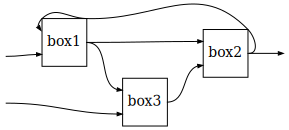

In [3]:
# Closed diagram
diagram = WiringDiagram( [:1, :2], [:1] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [:1, :2], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1, :2], [:1]) );
box3 = add_box!( diagram, Box(:box3, [:1, :2], [:1]) );

# Connections
add_wires!(diagram, [
    (input_id(diagram),1) => (box1, 2)
    (input_id(diagram),2) => (box3, 2)
    (box2,1) => (box1,1)
    (box3,1) => (box2,2)
    (box1,1) => (box2,1)
    (box1,1) => (box3,1)
    (box2,1) => (output_id(diagram),1)
])

show_diagram(diagram)  # Question: What happens if many wires connect at the same input port? [Add signals?]

Each box requires a dynamics equation. This encodes the behavior of the box with respect to itself, any external inputs, and time. These can be arbitrary so long as they are self consistent. An equation cannot expect an input if its associated box has no inputs.

In [4]:
#- Coefficients
# Mass #1
k1 = 1;     
c1 = 2;

# Mass #2
k2 = 1; 
c2 = 4;

# Parameters for ODE Solver:
x_init = [0.1, 2];               # External input: Taken as the ID of a box. How to store external state?
u_init = [1, 0, 0, 0, 1];        # Initial conditions
t_span = (0, 20);                # Interval of solution

In [5]:
#- Dynamic equations:
dynamic_1(u, x, p, t) = [ u[2], -k1*(u[1] - x[1]) - c1*(u[2]-x[2]) ];     # Two states, 2 input
dynamic_2(u, x, p, t) = [ -k2*(u[1] - x[1]) + k1*x[2] ];                  # One state, 1 input

# Array of dynamics functions 
dynamics = [dynamic_1, dynamic_2, dynamic_1];                   

### Algorithm to assign semantics

With the above infomation it is possible to link each box to with an equation. The following function performs the required steps for automatically. It returns an object that can be fed to an ODE solver.

In [6]:
function set_semantics( diagram::WiringDiagram, dynamics::Array{Function,1} )    
    
    #------- Determine Box parameters -------

    #- Find the output length of a function:    Note: Cleaner alternative? 
    
    function output_size(func)
        # Initial guess of element count
        n_out = 10;  

        # Evaluate function until it successfully executes
        while true
            # Test array (contents do not matter)
            array = Array{Float64,1}(undef, n_out);
            try 
                # Find the number of elemets in the output
                n_out = length( func(array, array, array, NaN) );
                break;
            catch (error)
                # Increase the array size if unsuccessful
                n_out *= 10; 
            end
        end
        return n_out;
    end
    
    #- Number of boxes
    count = nboxes(diagram);   

    # Initialize arrays
    n_input = Array{Int64,1}(undef, count);
    n_output = Array{Int64,1}(undef, count);
    n_state = Array{Int64,1}(undef, count);

    # Store the number of ports per box    
    for i = 1:count
        # Inputs and outputs are determined by wires
        n_input[i] = length( input_ports(diagram, i) );
        n_output[i] = length( output_ports(diagram, i) );
        
        # States are determined by equations
        n_state[i] = output_size(dynamics[i])
    end 

    #- Find input connections between boxes:
    input_box_id = Array{Array{Int,1},1}(undef, count);

    # Scan all boxes in the diagram
    for i = 1:count
        # Find input wires 
        in_wire = in_wires(diagram, i);
        in_count = length(in_wire);

        # Find the Id of boxes sending a wire
        id = Array{Int,1}(undef, in_count);
        
        for k = 1:in_count
            id[k] = in_wire[k].source.box;
        end

        # Store ID of boxes emitting to the i-th box
        setindex!(input_box_id, id, i);
    end
    
    #------- Readout functions -------
    
    readout = Array{Function,1}(undef, count);

    # Output state of each box
    for i = 1:count
        function send_pointer(u)    
            # Convert state pointer to float
            ptr = Float64(UInt64( pointer(u) ));
            
            # Send state pointer across each output port
            return repeat( [ptr], inner = n_output[i] );
        end

        # Store function
        setindex!( readout, send_pointer, i );
    end
    
    #------- Receive input pointers and update state -------
    
    dyn_function = Array{Function,1}(undef, count);

    # Modify the dynamics functions of each box
    for i = 1:count
        function receive_pointer(u, x, p, t)    
            # Initialize input
            xin = [];
            
            # Iterate across all elements of input
            for k = 1:length(x)
                # Id number of input
                id  = input_box_id[i][k];

                # For an External input, use raw value
                if id == -2 
                    xin = [xin; x[k]];  # Assumes 1 value per wire

                # For a Box input, convert to pointer 
                else 
                    # Retrieve array from pointer
                    ptr = Ptr{Float64}(UInt64( x[k] )); 
                    vec = unsafe_wrap(Vector{Float64}, ptr, n_state[id], own=false); 
                    
                    # Append vector
                    xin = [xin; vec];
                end  
            end    
            # Update state with retrieved input vector
            x = xin;
            return dynamics[i](u, x, p, t);    
        end

        # Store modified dynamics function
        setindex!( dyn_function, receive_pointer, i);
    end
    
    #------- Define machine for each box in the diagram -------
    
    machine = Array{ContinuousMachine{Float64}}(undef, count);

    for i = 1:count
        machine[i] = ContinuousMachine{Float64}( n_input[i], n_state[i], n_output[i], dyn_function[i], readout[i] );
    end

    # Compose machines with the diagram
    return oapply(diagram, machine);
end

set_semantics (generic function with 1 method)

### Display output

The dynamics equations can be ascribed to the diagram by calling the function. The output can then be used to investigate the behavior of the system. This is accomplished by solving the resulting equations with an ODE Solver.

In [7]:
# Compose system
net_machine = set_semantics(diagram, dynamics);

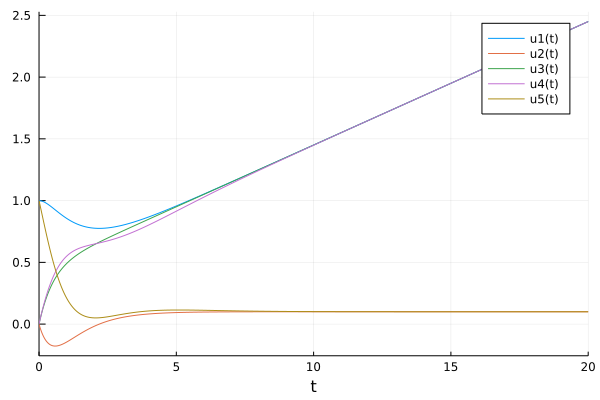

In [8]:
#- Solve system:

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, x_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)